In [27]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.weightstats import ttest_ind
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import statsmodels.api as sm

In [28]:
full_df = pd.read_csv("data/testing_data_NR.csv", index_col=0)
dpw_wrk_aux = pd.read_csv("data/DPW_wrk_aux.csv")

In [29]:
full_df.head()

,local_timestamp,epoch,datetime,node_file_id,no2_aux,o3_wrk_aux,no_wrk_aux,temp,rh,node_id,datetime_utc,true_no2
0,2024-12-16 00:00:00,1.734336e+09,2024-12-16 08:00:00,5293194,0.32365,0.00194,0.02246,NaN,NaN,276,2024-12-16 08:00:00,20.779
1,2024-12-16 00:01:00,1.734336e+09,2024-12-16 08:01:00,5293194,0.32384,0.00265,0.02224,6.49000,44.48500,276,2024-12-16 08:01:00,19.832
2,2024-12-16 00:02:00,1.734336e+09,2024-12-16 08:02:00,5293194,NaN,NaN,NaN,NaN,NaN,276,2024-12-16 08:02:00,19.827
3,2024-12-16 00:03:00,1.734336e+09,2024-12-16 08:03:00,5293194,0.32328,0.00247,0.02145,6.49917,44.48120,276,2024-12-16 08:03:00,17.530
4,2024-12-16 00:04:00,1.734336e+09,2024-12-16 08:04:00,5293194,0.32330,0.00273,0.02146,6.49615,44.38477,276,2024-12-16 08:04:00,19.350


In [30]:
dpw_wrk_aux.head()

,local_timestamp,epoch,datetime,node_file_id,no2_wrk_aux,node_id
0,2024-12-16 00:00:00,1.734336e+09,2024-12-16 08:00:00,5293194,-0.00530,276
1,2024-12-16 00:01:00,1.734336e+09,2024-12-16 08:01:00,5293194,-0.00566,276
2,2024-12-16 00:02:00,1.734336e+09,2024-12-16 08:02:00,5293194,NaN,276
3,2024-12-16 00:03:00,1.734336e+09,2024-12-16 08:03:00,5293194,-0.00518,276
4,2024-12-16 00:04:00,1.734336e+09,2024-12-16 08:04:00,5293194,-0.00512,276


In [31]:
full_merged = pd.merge(full_df, dpw_wrk_aux[["datetime", "no2_wrk_aux"]], on="datetime", how="left")

In [32]:
full_merged.head()
full_merged.to_csv("full_training_data.csv")

In [33]:
def summarize_missing_values(df, columns, time_column="datetime", freq="M"):
    df = df.copy()
    df[time_column] = pd.to_datetime(df[time_column])
    df.set_index(time_column, inplace=True)

    summary = {}

    for col in columns:
        total = len(df)
        missing = df[col].isna().sum()
        percent = 100 * missing / total

        monthly_missing = df[col].isna().resample("ME").sum()
        monthly_missing_counts = monthly_missing[monthly_missing > 0].astype(int).to_dict()

        summary[col] = {
            "Total Observations": total,
            "Missing Values": missing,
            "Missing (%)": round(percent, 2),
            "Missing by Month": monthly_missing_counts
        }

    return pd.DataFrame(summary).T


In [34]:
summary_df = summarize_missing_values(full_merged, columns=[
    "no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh", "true_no2", "no2_wrk_aux"
], time_column="datetime_utc")

print(summary_df[["Total Observations", "Missing Values", "Missing (%)"]])

for col in summary_df.index:
    print(f"\nMissing by Month for '{col}':")
    for month, count in summary_df.loc[col, "Missing by Month"].items():
        print(f"  {month.strftime('%Y-%m')}: {count}")


            Total Observations Missing Values Missing (%)
no2_aux                 184470           2206         1.2
o3_wrk_aux              184470           2206         1.2
no_wrk_aux              184470           2206         1.2
temp                    184470           8366        4.54
rh                      184470           8366        4.54
true_no2                184470            276        0.15
no2_wrk_aux             184470           2206         1.2

Missing by Month for 'no2_aux':
  2024-12: 577
  2025-01: 866
  2025-02: 703
  2025-03: 30
  2025-04: 30

Missing by Month for 'o3_wrk_aux':
  2024-12: 577
  2025-01: 866
  2025-02: 703
  2025-03: 30
  2025-04: 30

Missing by Month for 'no_wrk_aux':
  2024-12: 577
  2025-01: 866
  2025-02: 703
  2025-03: 30
  2025-04: 30

Missing by Month for 'temp':
  2024-12: 2280
  2025-01: 3345
  2025-02: 2681
  2025-03: 30
  2025-04: 30

Missing by Month for 'rh':
  2024-12: 2280
  2025-01: 3345
  2025-02: 2681
  2025-03: 30
  2025-04: 30

M

In [35]:
from scipy.stats import pearsonr

def plot_correlation(df, x_cols, y_col="true_no2", method="pearson"):
    df = df[[y_col] + x_cols].dropna()
    n = len(x_cols)
    plt.figure(figsize=(6 * n, 5))

    for i, x in enumerate(x_cols):
        plt.subplot(1, n, i + 1)
        sns.regplot(x=x, y=y_col, data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

        if method == "pearson":
            r, _ = pearsonr(df[x], df[y_col])
        elif method == "spearman":
            r = df[[x, y_col]].corr(method="spearman").iloc[0, 1]

        plt.title(f"{x} vs {y_col}\n{method.capitalize()} r = {r:.3f}")
        plt.xlabel(x)
        plt.ylabel(y_col)
        plt.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


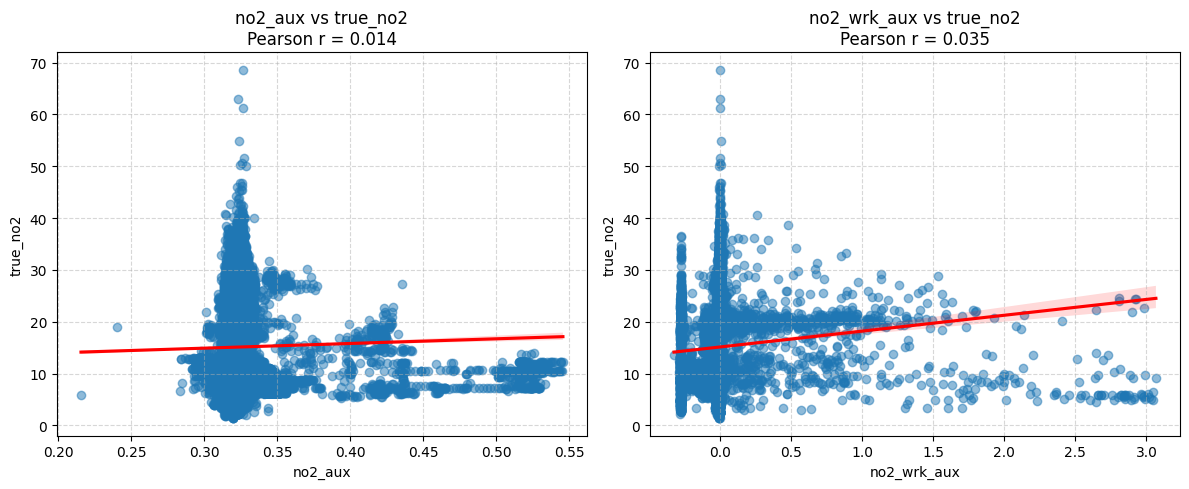

In [36]:
plot_correlation(full_merged, x_cols=["no2_aux", "no2_wrk_aux"], y_col="true_no2", method="pearson")


In [37]:
#doing some EDA an hour of day type data
full_merged["hour"] = pd.to_datetime(full_merged["datetime_utc"]).dt.hour

In [38]:
def plot_hourly_no2(df, hour, value_col="true_no2", datetime_col="datetime_utc", bins=30):
    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df["hour"] = df[datetime_col].dt.hour

    subset = df[df["hour"] == hour]

    if subset.empty:
        print(f"No data found for hour {hour}.")
        return

    plt.figure(figsize=(7, 4))
    plt.hist(subset[value_col], bins=bins, color="skyblue", edgecolor="black", alpha=0.7, density=False)
    plt.title(f"Histogram of {value_col} at Hour {hour:02d}:00")
    plt.xlabel("NO2 (ppb)")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

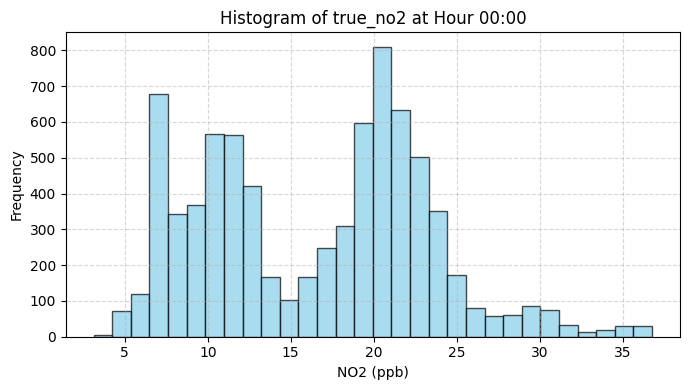

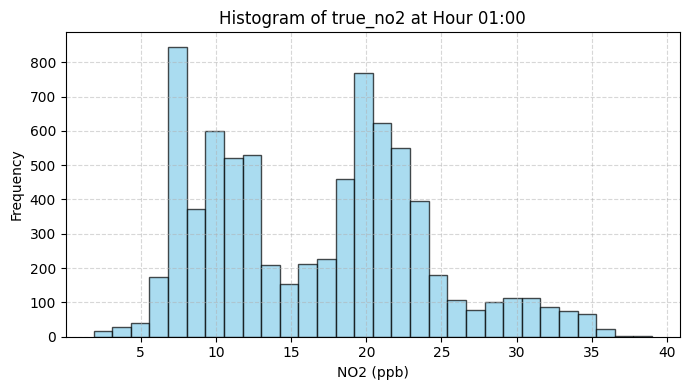

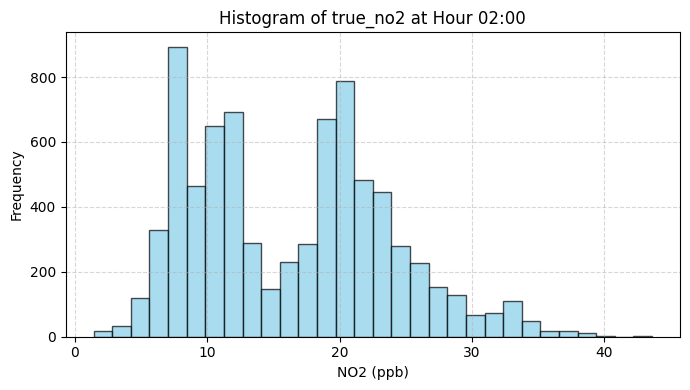

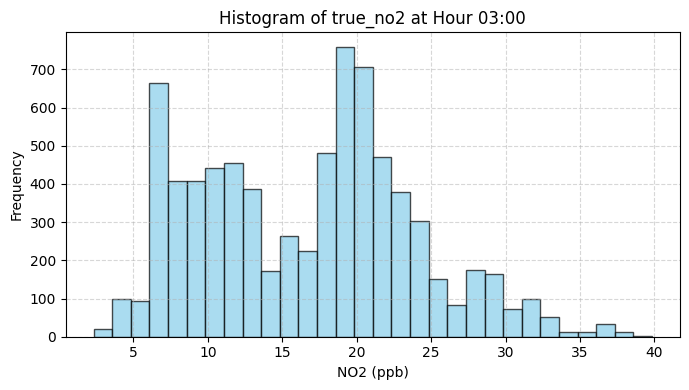

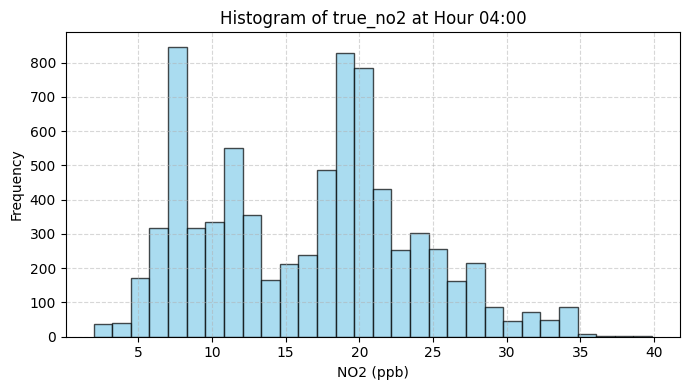

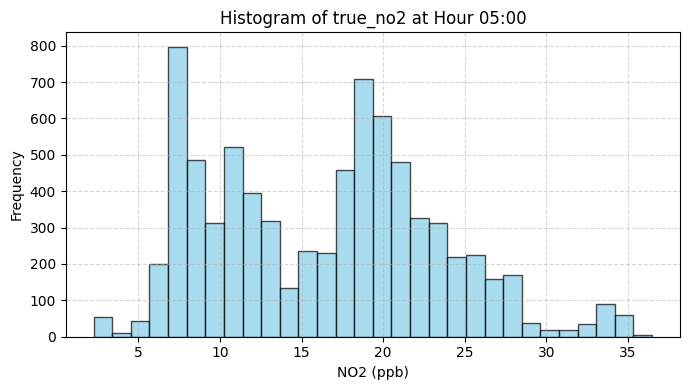

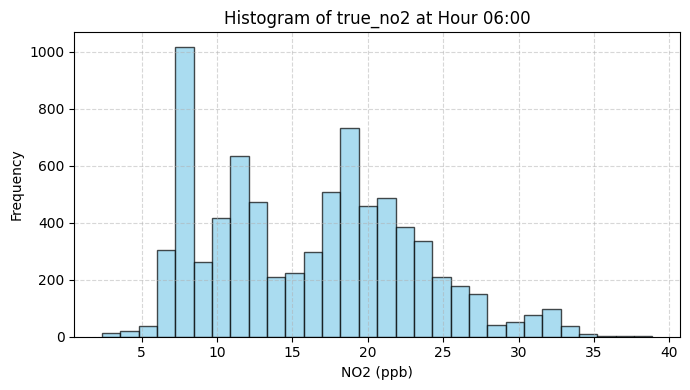

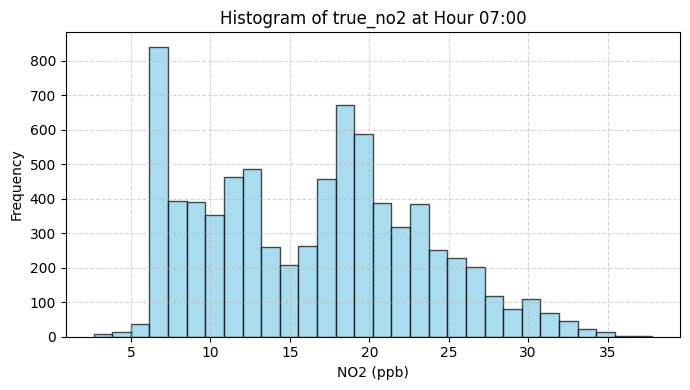

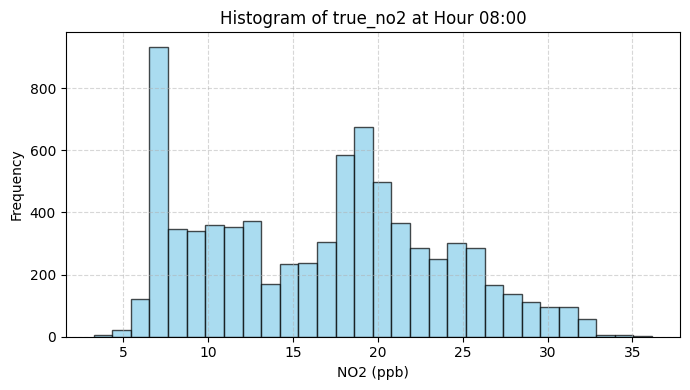

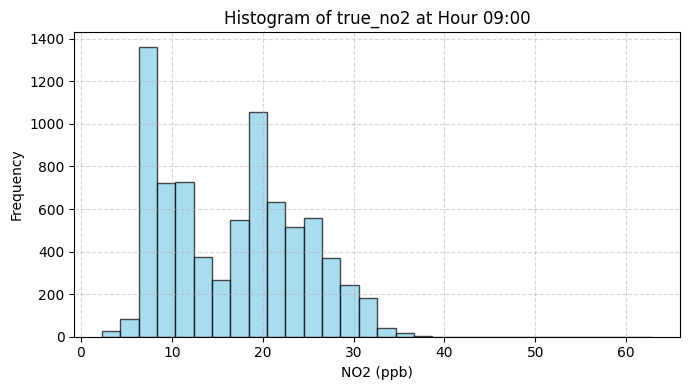

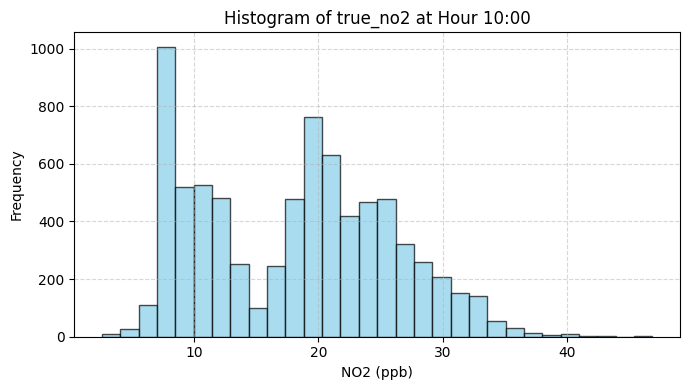

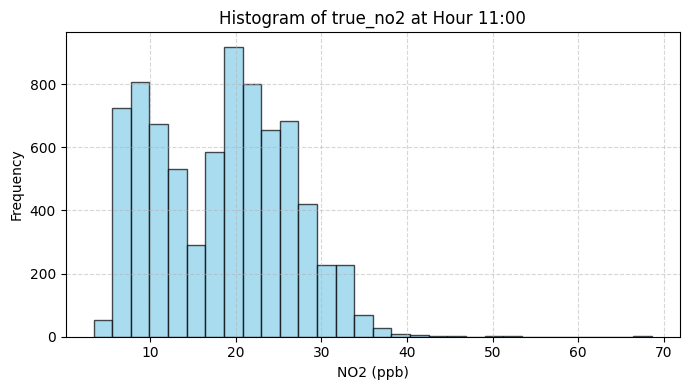

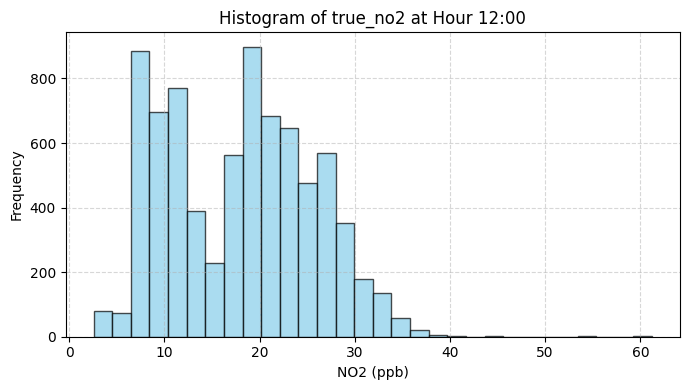

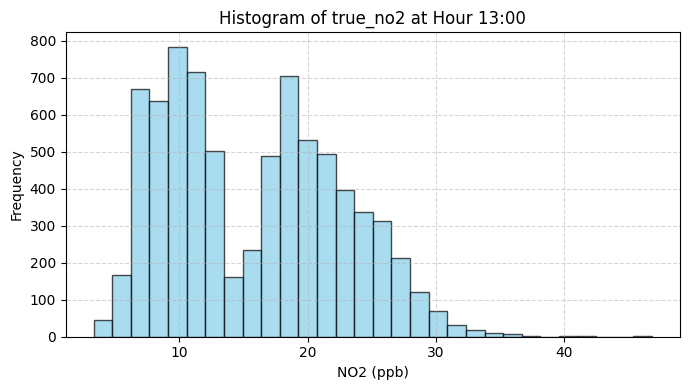

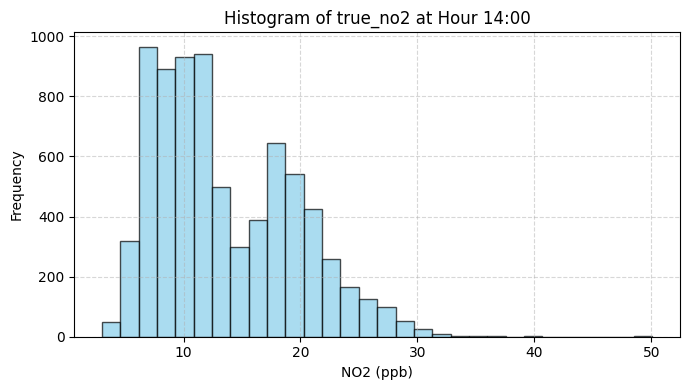

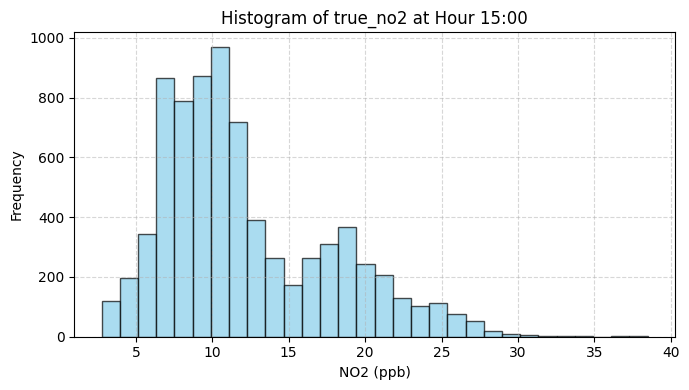

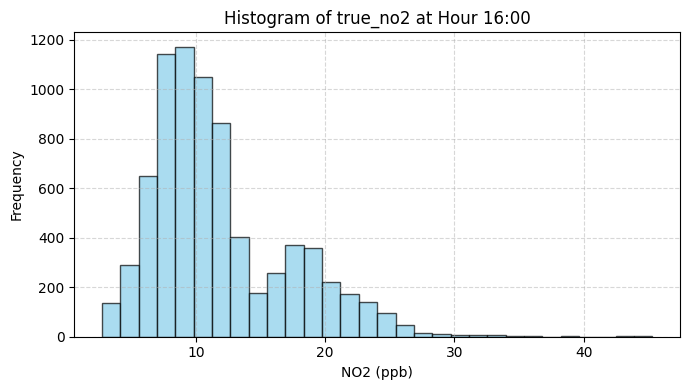

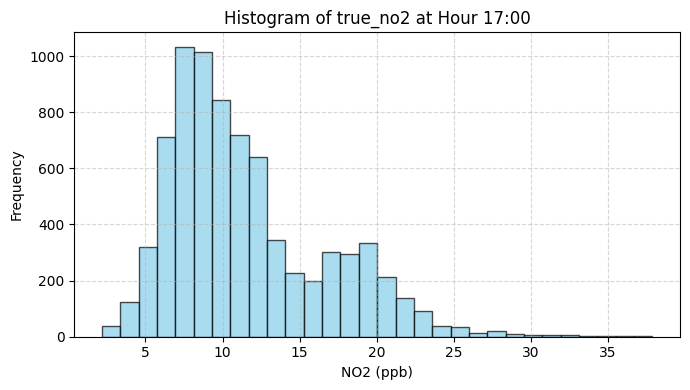

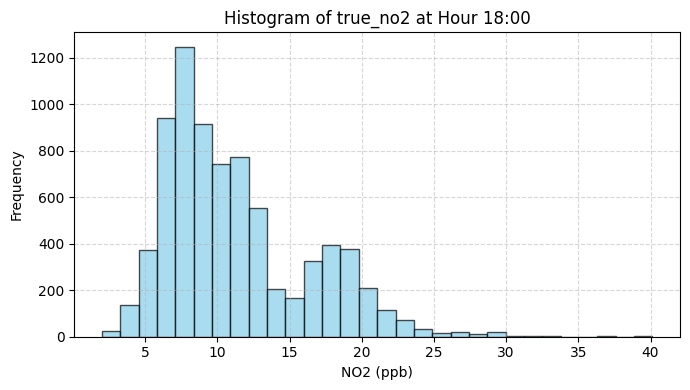

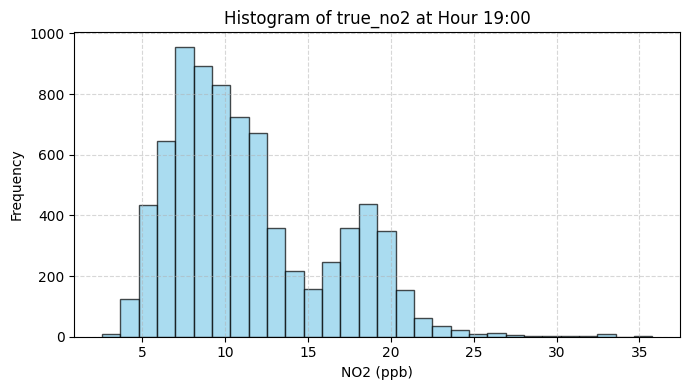

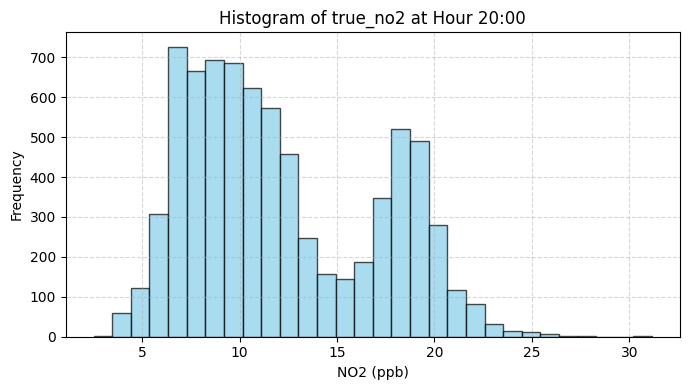

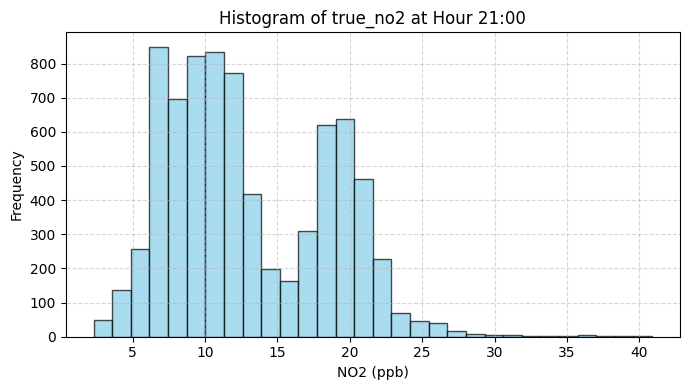

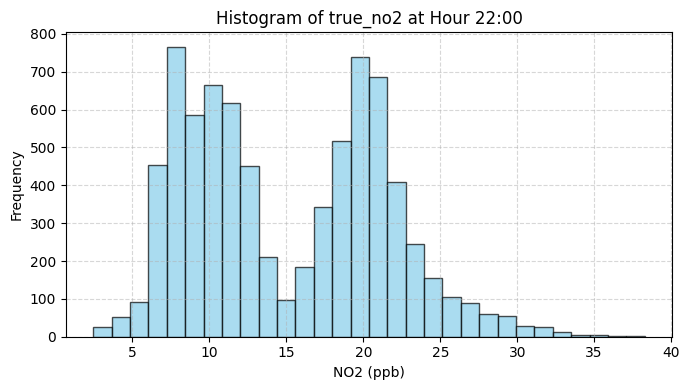

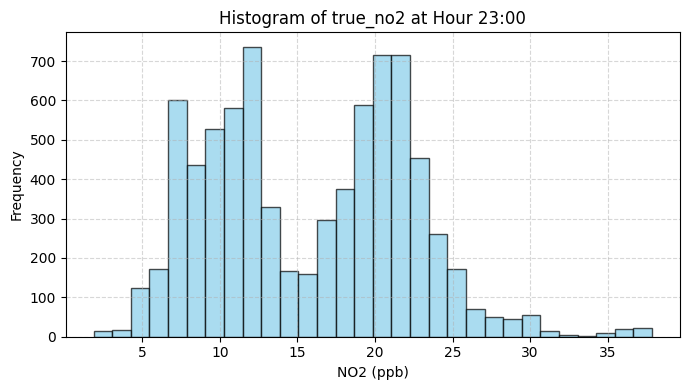

In [39]:
for hour in range(24):
    plot_hourly_no2(full_merged, hour=hour)

In [40]:
def plot_am_pm_no2_distributions(df, value_col="true_no2", datetime_col="datetime_utc", bins=30):
    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df["utc_hour"] = df[datetime_col].dt.hour

    before_noon = df[(df["utc_hour"] >= 5) & (df["utc_hour"] < 17)][value_col].dropna()

    after_noon = df[(df["utc_hour"] < 5) | (df["utc_hour"] >= 17)][value_col].dropna()

    plt.figure(figsize=(8, 5))
    plt.hist(before_noon, bins=bins, alpha=0.6, label="Before Noon EST", color="skyblue", edgecolor="k", density=True)
    plt.hist(after_noon, bins=bins, alpha=0.6, label="After Noon EST", color="salmon", edgecolor="k", density=True)
    plt.title(f"Distribution of {value_col}: Before vs After Noon (EST)")
    plt.xlabel("NO2 (ppb)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


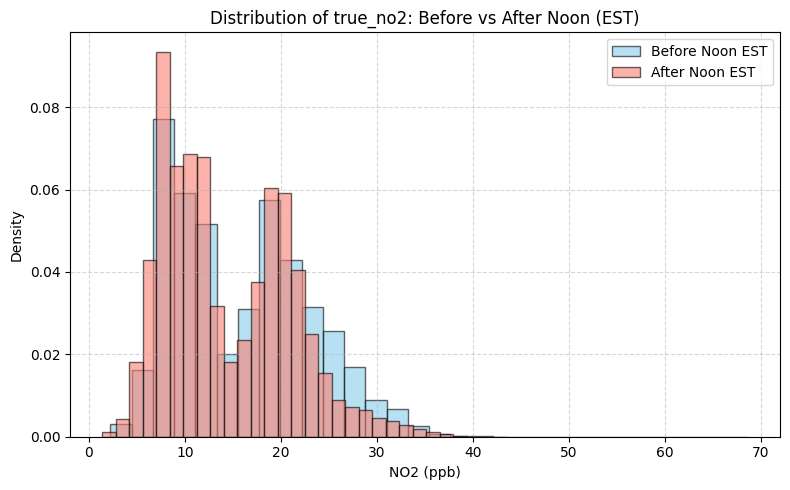

In [41]:
plot_am_pm_no2_distributions(full_merged)

In [42]:
def plot_no2_by_temp_terciles(df, temp_col="temp", value_col="true_no2", bins=30):
    df = df.copy()
    df = df[[temp_col, value_col]].dropna()

    q1 = df[temp_col].quantile(1/3)
    q2 = df[temp_col].quantile(2/3)

    low = df[df[temp_col] <= q1][value_col]
    mid = df[(df[temp_col] > q1) & (df[temp_col] <= q2)][value_col]
    high = df[df[temp_col] > q2][value_col]

    plt.figure(figsize=(8, 5))
    plt.hist(low, bins=bins, alpha=0.6, label="Low Temp (Bottom 33%)", color="cornflowerblue", edgecolor="k", density=True)
    plt.hist(mid, bins=bins, alpha=0.6, label="Mid Temp (Middle 33%)", color="gold", edgecolor="k", density=True)
    plt.hist(high, bins=bins, alpha=0.6, label="High Temp (Top 33%)", color="salmon", edgecolor="k", density=True)

    plt.title("NO2 Distribution by Temperature Tercile")
    plt.xlabel("NO2 (ppb)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


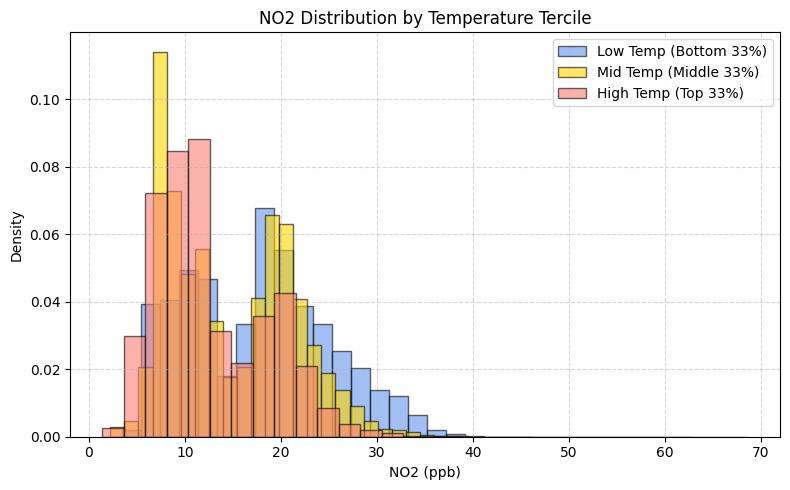

In [43]:
plot_no2_by_temp_terciles(full_merged)

In [44]:
def plot_no2_by_month(df, datetime_col="datetime_utc", value_col="true_no2", bins=30):
    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df["month"] = df[datetime_col].dt.month

    for m in range(1, 13):
        subset = df[df["month"] == m][value_col].dropna()
        if subset.empty:
            continue

        plt.figure(figsize=(6, 4))
        plt.hist(subset, bins=bins, color="mediumpurple", edgecolor="black", alpha=0.7, density=True)
        plt.title(f"NO2 Histogram for Month {m:02d}")
        plt.xlabel("NO2 (ppb)")
        plt.ylabel("Density")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()


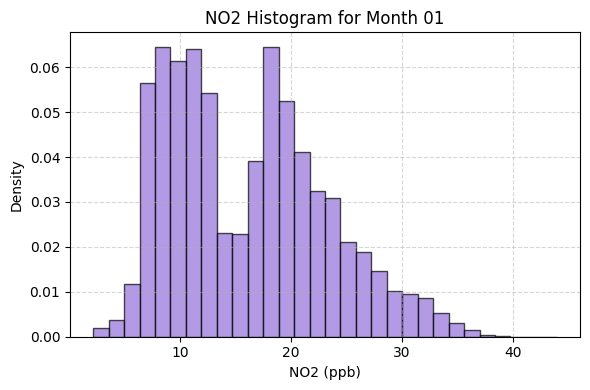

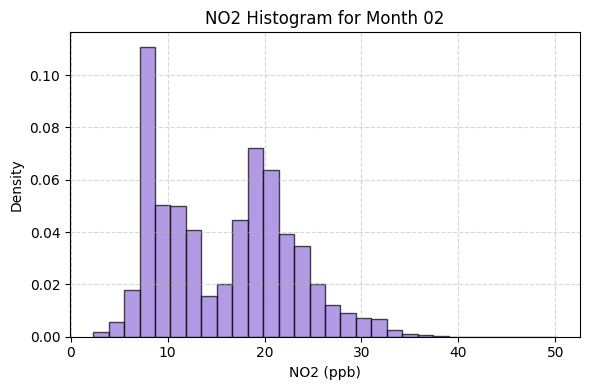

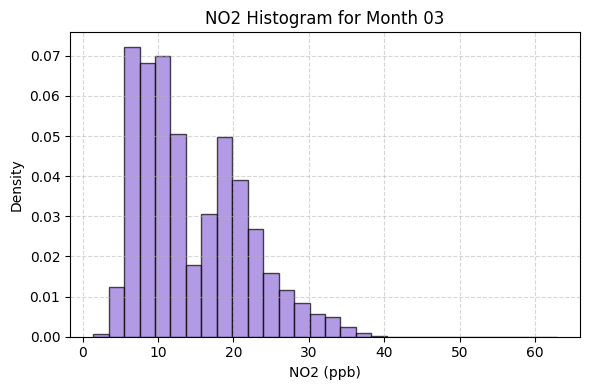

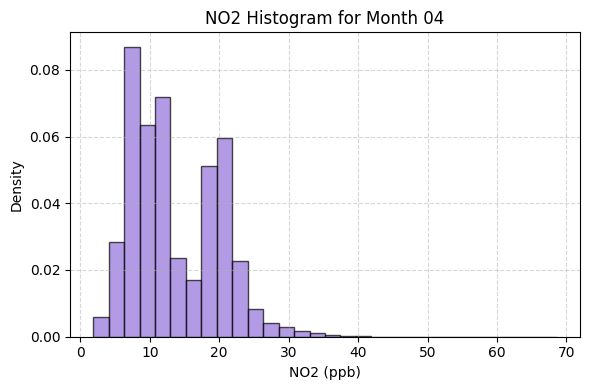

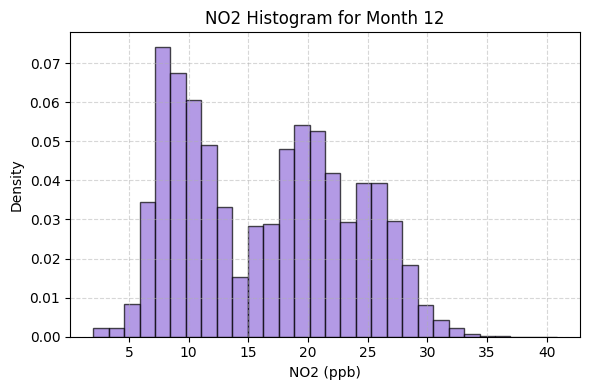

In [45]:
plot_no2_by_month(full_merged)